Gaussian White Noise Restoration via SC
=======================================

This example demonstrates the removal of Gaussian white noise from a colour image using sparse coding.

In [1]:
from __future__ import print_function
from builtins import input

import pyfftw   # See https://github.com/pyFFTW/pyFFTW/issues/40
import numpy as np

from sporco import util
from sporco import array
from sporco import plot
plot.config_notebook_plotting()
import sporco.metric as sm
from sporco.admm import bpdn

Load a reference image and corrupt it with Gaussian white noise with $\sigma = 0.1$. (The call to ``numpy.random.seed`` ensures that the pseudo-random noise is reproducible.)

In [2]:
img = util.ExampleImages().image('monarch.png', zoom=0.5, scaled=True,
                                 idxexp=np.s_[:, 160:672])
np.random.seed(12345)
imgn = img + np.random.normal(0.0, 0.1, img.shape)

Extract blocks and center each channel of image patches, taking steps of size 2.

In [3]:
blksz = (8, 8, 3)
stpsz = (2, 2, 1)

blocks = array.extract_blocks(imgn, blksz, stpsz)
blockmeans = np.mean(blocks, axis=(0, 1))
blocks -= blockmeans
blocks = blocks.reshape(np.product(blksz), -1)

Load dictionary.

In [4]:
D = util.convdicts()['RGB:8x8x3x64'].reshape(np.product(blksz), -1)

Set solver options.

In [5]:
lmbda = 1e-1
opt = bpdn.BPDN.Options({'Verbose': True, 'MaxMainIter': 250,
                         'RelStopTol': 3e-3, 'AuxVarObj': False,
                         'AutoRho': {'Enabled': False}, 'rho':
                         1e1*lmbda})

Initialise the [admm.bpdn.BPDN](http://sporco.rtfd.org/en/latest/modules/sporco.admm.bpdn.html#sporco.admm.bpdn.BPDN) object and call the ``solve`` method.

In [6]:
b = bpdn.BPDN(D, blocks, lmbda, opt)
X = b.solve()

Itn   Fnc       DFid      Regℓ1     r         s       
------------------------------------------------------
   0  2.20e+04  1.64e+04  5.59e+04  4.13e-01  1.40e+00


   1  2.12e+04  1.63e+04  4.94e+04  1.92e-01  4.61e-01
   2  2.08e+04  1.59e+04  4.89e+04  1.03e-01  2.41e-01
   3  2.07e+04  1.59e+04  4.79e+04  6.25e-02  1.44e-01


   4  2.05e+04  1.59e+04  4.69e+04  3.97e-02  9.37e-02
   5  2.05e+04  1.58e+04  4.64e+04  2.67e-02  6.46e-02
   6  2.04e+04  1.58e+04  4.61e+04  1.87e-02  4.69e-02


   7  2.04e+04  1.58e+04  4.60e+04  1.36e-02  3.55e-02
   8  2.04e+04  1.58e+04  4.59e+04  1.03e-02  2.77e-02
   9  2.04e+04  1.58e+04  4.58e+04  7.94e-03  2.22e-02


  10  2.04e+04  1.58e+04  4.57e+04  6.28e-03  1.82e-02
  11  2.04e+04  1.58e+04  4.57e+04  5.07e-03  1.51e-02
  12  2.04e+04  1.58e+04  4.57e+04  4.16e-03  1.27e-02


  13  2.04e+04  1.58e+04  4.57e+04  3.46e-03  1.08e-02
  14  2.04e+04  1.58e+04  4.57e+04  2.91e-03  9.26e-03
  15  2.04e+04  1.58e+04  4.57e+04  2.47e-03  8.00e-03
  16  2.04e+04  1.58e+04  4.57e+04  2.12e-03  6.97e-03


  17  2.04e+04  1.58e+04  4.57e+04  1.84e-03  6.11e-03
  18  2.04e+04  1.58e+04  4.57e+04  1.60e-03  5.38e-03
  19  2.04e+04  1.58e+04  4.57e+04  1.40e-03  4.75e-03
  20  2.04e+04  1.58e+04  4.57e+04  1.24e-03  4.22e-03


  21  2.04e+04  1.58e+04  4.57e+04  1.10e-03  3.75e-03
  22  2.04e+04  1.58e+04  4.57e+04  9.72e-04  3.35e-03
  23  2.04e+04  1.58e+04  4.57e+04  8.67e-04  2.99e-03
------------------------------------------------------


The denoised estimate of the image is by aggregating the block reconstructions from the coefficient maps.

In [7]:
imgd_mean = array.average_blocks(np.dot(D, X).reshape(blksz + (-1,))
                                 + blockmeans, img.shape, stpsz)
imgd_median = array.combine_blocks(np.dot(D, X).reshape(blksz + (-1,))
                                   + blockmeans, img.shape, stpsz, np.median)

Display solve time and denoising performance.

In [8]:
print("BPDN solve time: %5.2f s" % b.timer.elapsed('solve'))
print("Noisy image PSNR:    %5.2f dB" % sm.psnr(img, imgn))
print("Denoised mean image PSNR: %5.2f dB" % sm.psnr(img, imgd_mean))
print("Denoised median image PSNR: %5.2f dB" % sm.psnr(img, imgd_median))

BPDN solve time:  1.92 s
Noisy image PSNR:    20.47 dB
Denoised mean image PSNR: 27.09 dB
Denoised median image PSNR: 27.16 dB


Display the reference, noisy, and denoised images.

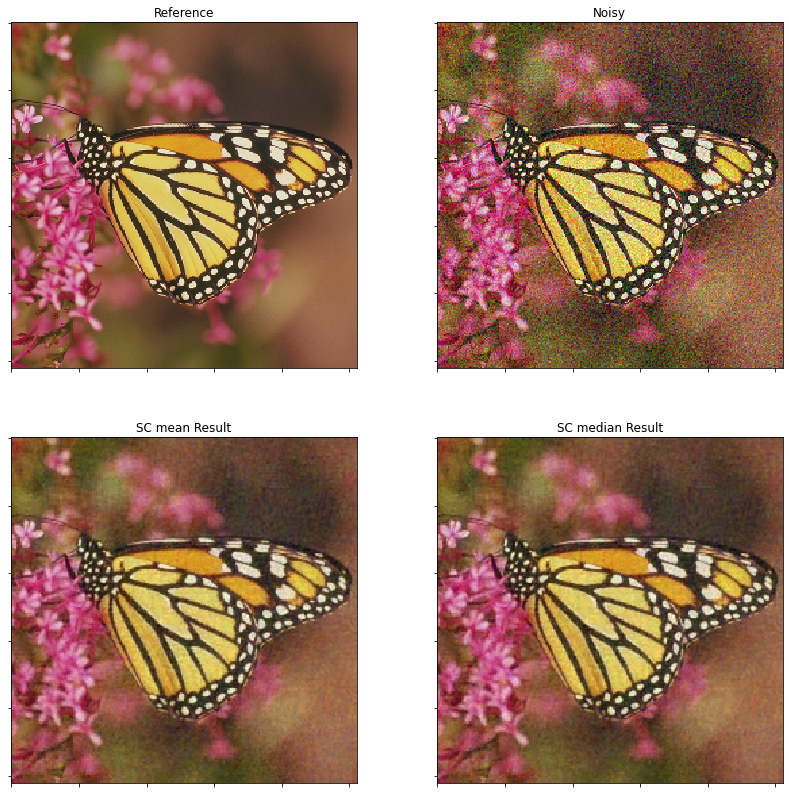

In [9]:
fig = plot.figure(figsize=(14, 14))
plot.subplot(2, 2, 1)
plot.imview(img, title='Reference', fig=fig)
plot.subplot(2, 2, 2)
plot.imview(imgn, title='Noisy', fig=fig)
plot.subplot(2, 2, 3)
plot.imview(imgd_mean, title='SC mean Result', fig=fig)
plot.subplot(2, 2, 4)
plot.imview(imgd_median, title='SC median Result', fig=fig)
fig.show()

Plot functional evolution during ADMM iterations.

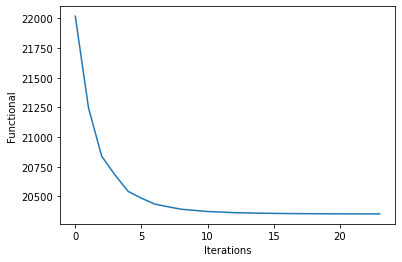

In [10]:
its = b.getitstat()
plot.plot(its.ObjFun, xlbl='Iterations', ylbl='Functional')